# DATA DICTIONARY

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

There are steps for creating this fraud detection machine learning model.
1) Import the data

2) Exploratory Data Analysis (EDA)

3) Data Cleaning

4) Feature Engineering 

5) Machine Learning to train the data

6) Test the Data

#  1) IMPORT

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import accuracy_score,classification_report,average_precision_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz
import warnings
warnings.filterwarnings('ignore')


Creating a dataFrame and importing the given csv file into it.

In [2]:
data = pd.read_csv('Fraud.csv')

In [3]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
data.rename(columns = {'oldbalanceOrg':'oldbalanceOrig'}, inplace = True)

In [5]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
data.shape

(1048575, 11)

In [7]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrig    float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

# 2)EXPLORATORY DATA ANALYSIS

First, let us find out which type of transactions are fraudulent.

In [8]:
data.loc[data.isFraud == 1].type.drop_duplicates().values


array(['TRANSFER', 'CASH_OUT'], dtype=object)

We find that only the 'TRANSFER' type and 'CASH_OUT' type are fraudulent.


Now lets see the number of fraudulent transactions in both of them.

In [9]:
datatransfer = data.loc[(data.isFraud == 1) & (data.type == 'TRANSFER')]
datacashout = data.loc[(data.isFraud == 1) & (data.type == 'CASH_OUT')]
print(f"The fraudulent transactions of 'TRANSFER' type are : {len(datatransfer)}") 
print(f"The fraudulent transactions of 'CASH_OUT' type are : {len(datacashout)}") 

The fraudulent transactions of 'TRANSFER' type are : 564
The fraudulent transactions of 'CASH_OUT' type are : 578


It appears that the fraudulent transactions in TRANSFER type and CASHOUT type are almost the same.

It also makes sense that frauds only happen when cash is transferred out to another recipient.

Therefore these are the key factors that effect the fraudulent transaction of a customer.
These factors absolutely makes sense. Although there are many external factors like phishing schemes, bank or company's own employee who possess the vital information that requires them to commit to a fraud against his employer and many criminals have found to steal money from unsuspected victims. These external factors can be prevented by spreading awareness about these crimes, limiting the cash limits and transaction limits, using a valid verification service before completing the transaction,etc.

Now let us talk about the isFlaggedFraud feature.

Lets see which type of transactions have this feature.

In [10]:
data['isFlaggedFraud'].value_counts()

0    1048575
Name: isFlaggedFraud, dtype: int64

Since all of the entries in isFlaggedFraud are set to 0.

We can discard it from the dataset.

If we observe, we see some 'M' prefixes in destination account names.

Lets check if we have any of them in the Originators account names

In [11]:
data.nameOrig.str.contains('M').any()

False

It returns false meaning there are no merchants in the originators account names.

Lets check if there are any other type of transactions with 'M' involved other than 'PAYMENT'

In [12]:
data.loc[data.nameDest.str.contains('M')].type.drop_duplicates().values

array(['PAYMENT'], dtype=object)

So there are no other type other than the 'PAYMENT' type

Hence we can conclude that among nameOrig and nameDest the prefix 'M' occurs in an unexpected way.

Lets check if there is any corelation between nameOrig, nameDest features and isFraud label

In [13]:
dataNotFraud = data.loc[data.isFraud == 0]
datatransfer.loc[datatransfer.nameDest.isin(dataNotFraud.loc[dataNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates().values)]


,step,type,amount,nameOrig,oldbalanceOrig,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud


Since there are none, we can be sure that fraudulent transactions are not indicated by nameOrig and nameDest

# 3) DATA CLEANING

We know that isFraud=1 is only present in type = ('TRANSFER','CASH_OUT'). So we only consider the corresponding data in the analysis

In [14]:
X = data.loc[(data.type == 'TRANSFER') | (data.type == 'CASH_OUT')]
np.random.seed(5)
# Y is the output.
Y = X['isFraud']
# Remove the unnecessary data
X = X.drop(['isFraud','nameOrig','nameDest','isFlaggedFraud'],axis=1)

In [15]:
# Binary Encoding of the labelled data in 'type'
X.loc[X.type=='TRANSFER','type'] = 0
X.loc[X.type=='CASH_OUT','type'] = 1
X.type = X.type.astype(int)

Imputation of the latent missing values

In [16]:
Xfraud = X.loc[Y==1]
Xnonfraud = X.loc[Y == 0]
print(f"The fraction of fraudulent transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 and transacted amount is not zero is :\n {len(Xfraud.loc[(Xfraud.oldbalanceDest == 0) & (Xfraud.newbalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))}")
print(f"The fraction of genuine transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 and transacted amount is not zero is :\n {len(Xnonfraud.loc[(Xnonfraud.oldbalanceDest == 0) & (Xnonfraud.newbalanceDest == 0) & (Xnonfraud.amount)]) / (1.0 * len(Xnonfraud))}")


The fraction of fraudulent transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 and transacted amount is not zero is :
 0.4754816112084063
The fraction of genuine transactions with 'oldbalanceDest' = 'newbalanceDest' = 0 and transacted amount is not zero is :
 0.002308100999015791


We can see that the destination balances being 0 is a strong dependent feature evaluating the fraud. We dont impute the account balance value for the amount transacted because doing so would mask this indicator of fraud and will make fraudulent transactions appear genuine. So instead, we replace 0 with -1.

In [17]:
X.loc[(X.oldbalanceDest == 0) & (X.newbalanceDest == 0) & (X.amount != 0),['oldbalanceDest', 'newbalanceDest']] = - 1

The data also has several transactions with zero balances in the originating account both before and after a non-zero amount is transacted. In this case, the fraction of such transactions is much smaller in fraudulent compared to genuine transactions. Once again, from similar reasoning as above, instead of imputing a numerical value we replace the value of 0 with a null value.

In [18]:
X.loc[(X.oldbalanceOrig == 0) & (X.newbalanceOrig == 0) & (X.amount != 0), \
      ['oldbalanceOrig', 'newbalanceOrig']] = np.nan

#  4) FEATURE ENGINEERING

Let us create 2 new features recording errors in the originating and destination accounts for each transaction. These new features turn out to be important in obtaining the best performance from the ML algorithm that we will finally use.

In [19]:
X['errorbalanceOrig'] = X.newbalanceOrig + X.amount - X.oldbalanceOrig
X['errorbalanceDest'] = X.oldbalanceDest + X.amount - X.newbalanceDest

# 5) DATA VISUALIZATION

The efficient way of continuing this model would be visualizing the data differences between fraudulent and genuine transactions.

In [79]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 2, 7))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x, y, hue = hue, jitter = 0.4, marker = '.', size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), loc=2, borderaxespad=0, fontsize = 16);
    return ax

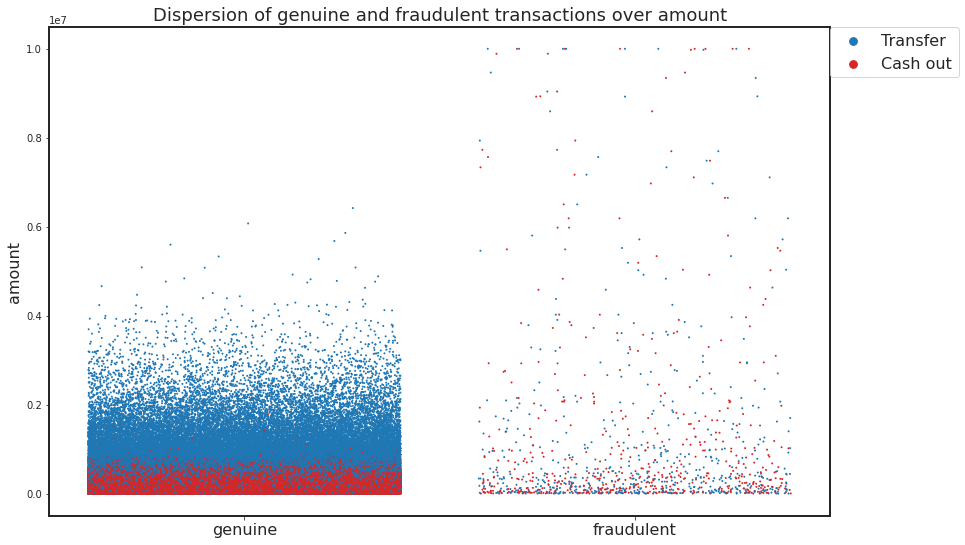

In [80]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Dispersion of genuine and fraudulent transactions over amount', size = 18);

The above plotted graph shows dispersion between genuine and fraudulent transactions over amount.

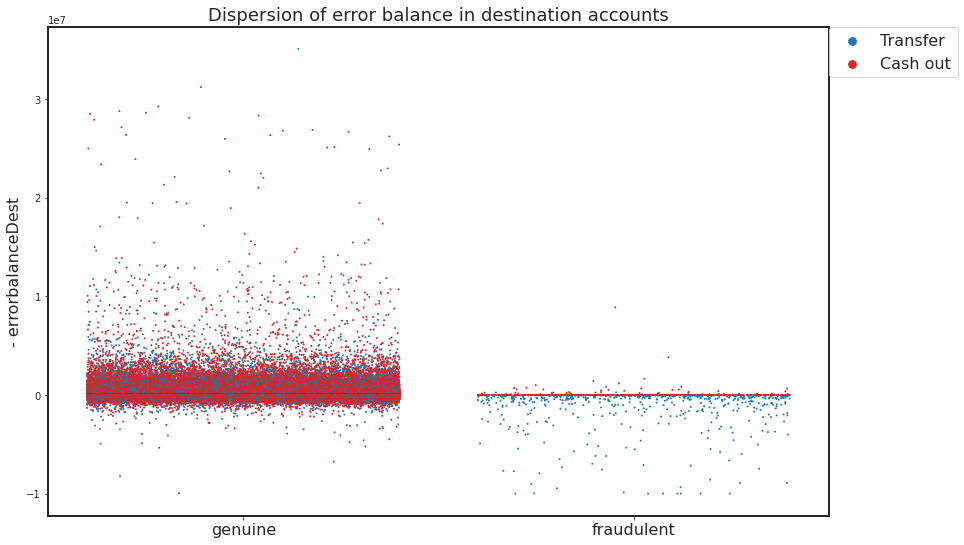

In [81]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorbalanceDest[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('- errorbalanceDest', size = 16)
ax.set_title('Dispersion of error balance in destination accounts', size = 18);

The above plotted graph shows dispersion between genuine and fraudulent transactions over errorbalance in destination accounts.

# 5) MACHINE LEARNING TO TRAIN THE DATA.

There is one more task left remaining before training a robust model is the highly imbalanced nature of the data.

In [21]:
print('skew = {}'.format( len(Xfraud) / float(len(X)) ))

skew = 0.002480484107090883


A disadvantage in this method (discarding the irrelevant information on the dataset) is that the model will not perform well on a real world skewed data since almost all the information was discarded. I think the most accurate result will be obtained using a ML algorithm with ensembles of decision trees that intrinsically performs well on imbalanced data. I used the extreme gradient boosting algorithm in this model (XGBoost Algorithm).

Split the data into training and testing sets in the ratio 80:20 

In [22]:
X_train, X_test, Y_train,Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 5)


In [23]:
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum())
clf = XGBClassifier(max_depth = 3, scale_pos_weight = weights, n_jobs = 4)
probabilities = clf.fit(X_train, Y_train).predict_proba(X_test)
print('AUPRC = {}'.format(average_precision_score(Y_test, probabilities[:, 1])))

AUPRC = 0.9777337575291319


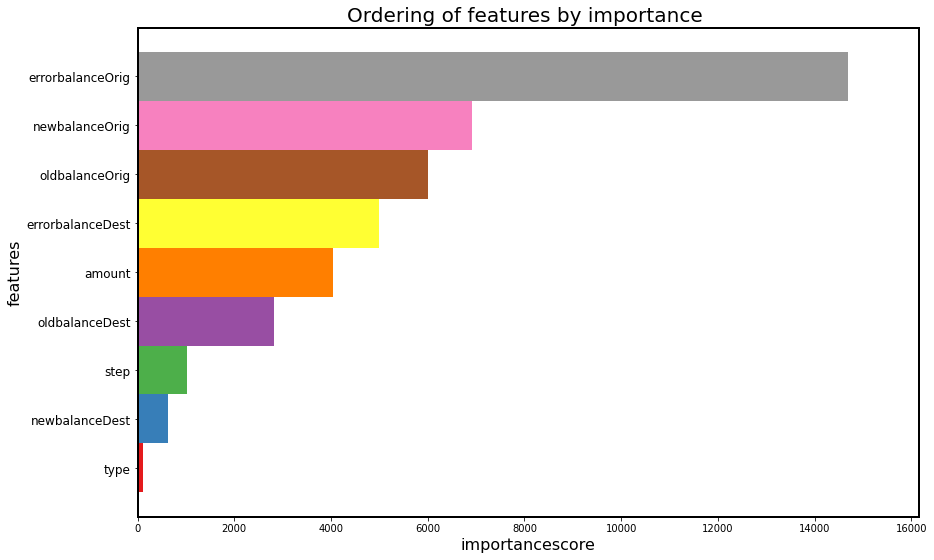

In [24]:
fig = plt.figure(figsize = (14, 9))
ax = fig.add_subplot(111)

colours = plt.cm.Set1(np.linspace(0, 1, 9))

ax = plot_importance(clf, height = 1, color = colours, grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)
        
ax.set_xlabel('importancescore', size = 16);
ax.set_ylabel('features', size = 16);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Ordering of features by importance ', size = 20);

Here we can see that the new feature that we created is having the most importance.

These are ordered based on samples affected by splits (also depends on the split done) on those features. 

In [25]:
xgb_model = XGBClassifier(n_estimators=1000)
xgb_model.fit(X_train, Y_train, eval_metric='merror')

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=1000,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

# 6) TEST THE DATA :


In [26]:
y_pred_train = xgb_model.predict(X_train)
y_pred_test = xgb_model.predict(X_test)
target = sorted(set(Y))

print(f'Training accuracy: {accuracy_score(Y_train,y_pred_train)}')
print(f'Training:\n {classification_report(Y_train, y_pred_train, labels=target)}')
print(f'Testing accuracy: {accuracy_score(Y_test,y_pred_test)}')
print(f'Testing:\n {classification_report(Y_test, y_pred_test, labels=target)}')

Training accuracy: 1.0
Training:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    367407
           1       1.00      1.00      1.00       908

    accuracy                           1.00    368315
   macro avg       1.00      1.00      1.00    368315
weighted avg       1.00      1.00      1.00    368315

Testing accuracy: 0.9999239783229618
Testing:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     91845
           1       1.00      0.97      0.98       234

    accuracy                           1.00     92079
   macro avg       1.00      0.99      0.99     92079
weighted avg       1.00      1.00      1.00     92079



We get testing accuracy as 0.99 which describes a highly accurate model.

Conclusion : We thoroughly interrogated the data to gain valuable insights like which features could be discarded and which could be valuably engineered. To deal with the large skew in the data, we choose an appropriate metric and used an ML algorithm based on an ensemble of decision trees which works best with highly imbalanced data. Frauds now a days have been the latest crime through out the world via many unethical ways. There are companies and banks who are taking necessary and important precautions regarding this activity. Although many people take this very casually which is why there are still number of criminals out there doing his/her job well. As I said above, spreading awareness, cash and transaction limits, using a valid verification before completing a transaction can be some of the ways which can reduce fraudulent transactions. People will become alert by these. Don't do financial transactions online, when using your mobile devices or computer in a public place or over an unsecured network. 